In [ ]:
import pandas as pd, numpy as np
import gzip
import os
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import random
import ast
from collections import defaultdict

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

# Check whether GPU is available and can be used
# if CUDA is found then device is set accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    print("Consider changing your run-time to GPU or training will be slow.")

In [ ]:
df = pd.read_csv('data/cleaned_df.csv')

In [ ]:
data = np.load('data/feature_array.npz')

# Retrieve the feature_arr array
arr = data['feature_arr']

# Make sure to close the npz file
data.close()

In [ ]:
arr_sorted = pd.DataFrame(arr).sort_values(by=[0,2]).values

array([[         0,      26018, 1357862400, ...,          0,          0,
                 0],
       [         0,      79428, 1357862400, ...,          0,          0,
                 0],
       [         0,     127752, 1362096000, ...,          0,          0,
                 0],
       ...,
       [     34645,      40841, 1093046400, ...,          0,          0,
                 0],
       [     34645,     109969, 1093046400, ...,          0,          0,
                 0],
       [     34645,      43253, 1093046400, ...,          0,          0,
                 0]], dtype=int32)

In [ ]:
user_series_train = {}
user_series_valid = {}
current_user_id = 0
start_index = 0

train_ratio = 0.99
random_index = np.unique(arr_sorted[:,0]).copy()
random.shuffle(random_index)
train_index = random_index[:int(len(random_index)*train_ratio)]
valid_index = random_index[int(len(random_index)*train_ratio):]

for i, row in enumerate(arr_sorted):
    user_id = row[0]

    if user_id != current_user_id:

        seq = arr[start_index:i,2]
        seq_lag = np.diff(seq)
        seq_lag = np.append(seq_lag, 0)
        # print(seq_lag.reshape(-1,1).shape)
        # print(arr[start_index:i,3:].shape)
        if user_id in train_index:
            user_series_train[current_user_id] = arr[start_index:i,3:]
            # user_series_train[current_user_id] = np.hstack([arr[start_index:i,3:],seq_lag.reshape(-1,1)])
        else:
            user_series_valid[current_user_id] = arr[start_index:i,3:]
            #user_series_valid[current_user_id] = np.hstack([arr[start_index:i,3:],seq_lag.reshape(-1,1)])

        current_user_id = user_id

        start_index = i

if current_user_id is not None:
    seq = arr[start_index:i,2]
    seq_lag = np.diff(seq)
    seq_lag = np.append(seq_lag, 0)
    if user_id in train_index:
        user_series_train[current_user_id] = arr[start_index:i,3:]
        #user_series_train[current_user_id] = np.hstack([arr[start_index:i,3:],seq_lag.reshape(-1,1)])
    else:
        user_series_valid[current_user_id] = arr[start_index:i,3:]
        #user_series_valid[current_user_id] = np.hstack([arr[start_index:i,3:],seq_lag.reshape(-1,1)])

In [ ]:
def get_batches(user_series, batch_size, seq_length):
    # Shuffle user IDs
    user_ids = list(user_series.keys())
    random.shuffle(user_ids)

    # Initialize batch
    batch_X, batch_y = [], []
    for user_id in user_ids:
        user_data = user_series[user_id]

        # Split user data into sequences of length seq_length
        for i in range(0, len(user_data) - seq_length - 1):
            sequence_X = user_data[i:i + seq_length]
            #sequence_y = user_data[i + 1:i + seq_length + 1, :-1]
            sequence_y = user_data[i + 1:i + seq_length + 1, :]

            # Add sequence to batch
            batch_X.append(sequence_X)
            batch_y.append(sequence_y[-1])  # Assuming we want to predict the next value

            # If batch is full, yield it and start a new one
            if len(batch_X) == batch_size:
                # try:
                yield np.array(batch_X), np.array(batch_y)
                # except Exception as e:
                #   print(e)
                #   for a in batch_X:
                #     print(a.shape)
                #   for b in batch_y:
                #     print(b.shape)
                batch_X, batch_y = [], []

    # # Yield any remaining data as the last batch
    # if batch_X:
    #     yield np.array(batch_X), np.array(batch_y)



In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, embedding_length, output_size, device, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__()

        self.device = device
        self.n_layers = n_layers
        self.n_hidden = n_hidden

        # define the LSTM
        self.lstm = nn.LSTM(embedding_length, n_hidden, n_layers, dropout=drop_prob, batch_first=True)

        # define a dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, output_size)

    def forward(self, x, hidden):
        ''' Forward pass through the network.
            The inputs are x, and the hidden & cell state in a tuple. '''

        # get the outputs and the new hidden states from the LSTM
        r_output, hidden = self.lstm(x, hidden)

        # pass through a dropout layer
        out = self.dropout(r_output)

        # Select the output of the last timestep for each sequence in the batch
        # Assuming out has shape [batch_size, seq_length, n_hidden]
        last_output = out[:, -1, :]  # This selects the last element from the second dimension (seq_length)

        # Calculate fully connected layer output
        out = self.fc(last_output)

        return out, hidden


    def init_hidden(self, batch_size=1):
        ''' Initializes hidden state '''
        # Create new tensors for LSTM hidden and cell states, initialized to zero
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(self.device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(self.device))
        return hidden


In [ ]:
import torch
import torch.nn as nn

def train(model, user_series_train, user_series_valid, device, optimizer, criterion, epochs=10, batch_size=10, seq_length=50, clip=5):

    train_losses = []
    valid_losses = []

    # Train the model
    for epoch in range(epochs):
        # Initialize hidden states
        model.train()

        h = model.init_hidden(batch_size)

        losses = 0
        count = 0

        for x, y in get_batches(user_series_train, batch_size, seq_length):
            # Convert to torch tensors and move to device
            inputs, targets = torch.from_numpy(x).float(), torch.from_numpy(y).float()

            inputs, targets = inputs.to(device), targets.to(device)

            # Detach hidden states
            h = tuple([each.data for each in h])

            # Zero accumulated gradients
            model.zero_grad()

            # Get the output and hidden state from the model
            output, h = model(inputs, h)

            # Calculate the loss and perform backprop
            loss = criterion(output, targets)
            losses += loss.item()
            count += 1
            loss.backward()

            # Clip gradients
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {losses/count:.4f}")
        train_losses.append(losses/count)

        # Validate the model
        model.eval()

        losses = 0
        count = 0
        model.eval()
        h = model.init_hidden(batch_size)

        for x, y in get_batches(user_series_valid, batch_size, seq_length):
            # Convert to torch tensors and move to device
            inputs, targets = torch.from_numpy(x).float(), torch.from_numpy(y).float()

            inputs, targets = inputs.to(device), targets.to(device)

            # Detach hidden states
            h = tuple([each.data for each in h])

            # Get the output and hidden state from the model
            output, h = model(inputs, h)

            # Calculate the loss and perform backprop
            loss = criterion(output, targets)
            losses += loss.item()
            count += 1

      print(f"Epoch: {epoch + 1}/{epochs}, Validation Loss: {losses/count:.4f}")
      valid_losses.append(losses/count)

    return train_losses, valid_losses

In [ ]:
# Define the model
n_hidden=512
n_layers=2

# model = LSTM(embedding_length=1000, output_size = 1000, device=device, n_hidden=512, n_layers=2, drop_prob=0.2).to(device)
model = LSTM(embedding_length=1000, output_size = 1000, device=device, n_hidden=512, n_layers=2, drop_prob=0.2).to(device)

In [ ]:
class L2DistanceLoss(nn.Module):
    def __init__(self):
        super(L2DistanceLoss, self).__init__()

    def forward(self, output, targets):
        # Calculate L2 distance between the output and target tensors
        loss = torch.norm(output - targets, dim=1, p=2).sum()  # Sum of L2 distances across dimension 1
        return loss


In [ ]:
# Define the model
n_hidden=512
n_layers=2

# model = LSTM(embedding_length=1000, output_size = 1000, device=device, n_hidden=512, n_layers=2, drop_prob=0.2).to(device)
model = LSTM(embedding_length=1000, output_size = 1000, device=device, n_hidden=512, n_layers=2, drop_prob=0.2).to(device)

In [ ]:
# Declaring the hyperparameters
batch_size = 128
seq_length = 5
epochs = 100 # start with 50 or similar if you are debugging
# train much longer if you want good results

optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
#criterion = nn.CrossEntropyLoss()
criterion = L2DistanceLoss()

# train the model
train_losses, valid_losses = train(model, user_series_train, user_series_valid, device, optimizer, criterion, epochs=epochs,
      batch_size=batch_size, seq_length=seq_length)

Epoch: 1/100, Train Loss: 116.5661
Epoch: 1/100, Validation Loss: 110.7932
Epoch: 2/100, Train Loss: 105.7677
Epoch: 2/100, Validation Loss: 105.1112
Epoch: 3/100, Train Loss: 101.8895
Epoch: 3/100, Validation Loss: 101.1832
Epoch: 4/100, Train Loss: 99.3732
Epoch: 4/100, Validation Loss: 99.2603
Epoch: 5/100, Train Loss: 97.5714
Epoch: 5/100, Validation Loss: 98.6354
Epoch: 6/100, Train Loss: 96.2020
Epoch: 6/100, Validation Loss: 94.9199
Epoch: 7/100, Train Loss: 95.1204
Epoch: 7/100, Validation Loss: 95.8721
Epoch: 8/100, Train Loss: 94.2553
Epoch: 8/100, Validation Loss: 93.9309
Epoch: 9/100, Train Loss: 93.5318
Epoch: 9/100, Validation Loss: 92.9409
Epoch: 10/100, Train Loss: 92.8839
Epoch: 10/100, Validation Loss: 91.4751
Epoch: 11/100, Train Loss: 92.3217
Epoch: 11/100, Validation Loss: 91.8824
Epoch: 12/100, Train Loss: 91.8230
Epoch: 12/100, Validation Loss: 91.2287
Epoch: 13/100, Train Loss: 91.3613
Epoch: 13/100, Validation Loss: 91.1633
Epoch: 14/100, Train Loss: 90.9462
Ep

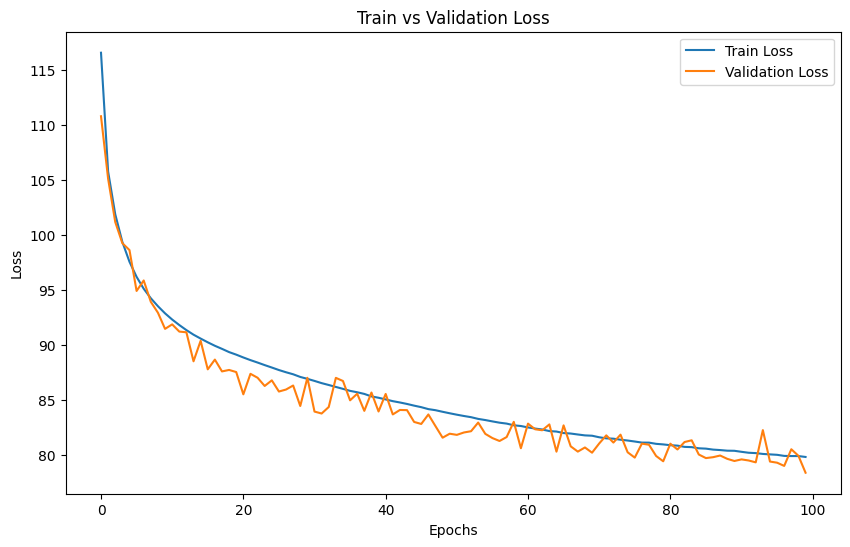

In [ ]:
# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.grid(True)
plt.show()

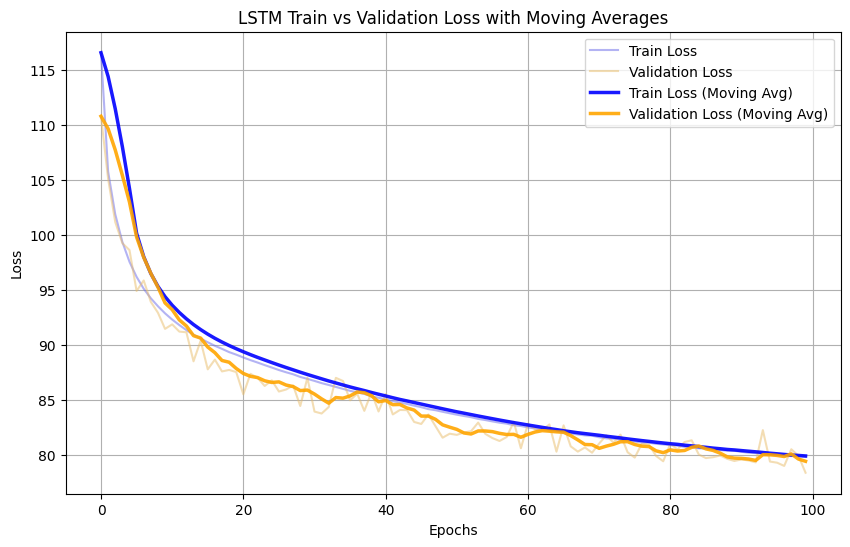

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have train_losses and valid_losses lists containing loss values

# Calculating moving average for better visualization
def moving_average(data, window_size):
    # Pad the data to ensure first window_size elements have a moving average
    padded_data = np.concatenate([data[0] * np.ones(window_size - 1), data])
    moving_avg = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')
    return moving_avg

window_size = 5  # Adjust the window size for the moving average

# Calculate moving averages for train and validation losses
train_losses_ma = moving_average(train_losses, window_size)
valid_losses_ma = moving_average(valid_losses, window_size)

# Plotting the line plot with moving averages
plt.figure(figsize=(10, 6))

# Plotting train and validation losses with a slight tint
plt.plot(train_losses, color='#6969e9', label='Train Loss', alpha=0.5)  # Slightly transparent train loss
plt.plot(valid_losses, color='#e9bc69', label='Validation Loss', alpha=0.5)  # Slightly transparent validation loss

# Plotting moving averages with emphasized colors
plt.plot(train_losses_ma, color='blue', label='Train Loss (Moving Avg)', linewidth=2.5, alpha=0.9)  # Emphasized moving average for train loss
plt.plot(valid_losses_ma, color='orange', label='Validation Loss (Moving Avg)', linewidth=2.5, alpha=0.9)  # Emphasized moving average for validation loss

plt.title('LSTM Train vs Validation Loss with Moving Averages')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('LSTM_loss_graph.pdf', format='pdf')

plt.show()

In [ ]:
torch.save(model, 'models/LSTM.pth')